In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
gait_dir = '/Users/iwoods/Documents/GitHub/gait/'
this_dir = os.getcwd()
os.chdir(gait_dir)
import gaitFunctions
from gaitFunctions import pairwiseStats
import combineClips
import plotClip
os.chdir(this_dir)
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

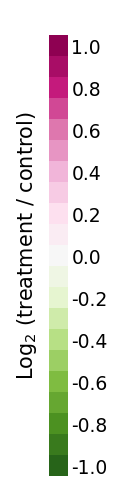

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#b45eff' # lavender
first_pair_color_alt = '#661f99' # purple
second_pair_color = '#006f2a' # green
second_pair_color_alt = '#02db55' # light green
third_pair_color = '#ffd500' # yellow
third_pair_color_alt = '#fa9805' # orange
rear_leg_color = '#00b6eb'# light blue
rear_leg_color_alt = '#0010eb' # dark blue

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# control vs. experimental colors
cmap = 'PiYG_r'

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

levels = np.linspace(-1,1,21)
ylevel = 0
f,ax = plt.subplots(figsize=(1,4), dpi=150, facecolor=(1,1,1,0))
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((0.1, ylevel), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(1.15,ylevel+0.15,str(np.round(level,1)),fontsize=tick_fontsize)
    ylevel += 1
ax.set_ylabel('Log$_{2}$ (treatment / control)')
ax.set_ylim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
# ax.set_axis_off()

plt.show()

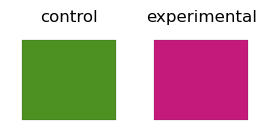

In [3]:
col_level = 0.8
con_color = getLevelColor('PiYG_r', -col_level)
exp_color = getLevelColor('PiYG_r', col_level)
palette = [con_color,exp_color]

f,[ax1,ax2] = plt.subplots(1,2,figsize=(2.8,1.5))
con_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=con_color)        
ax1.add_patch(con_square)
ax1.axis('off')
ax1.set_title('control')

exp_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=exp_color)        
ax2.add_patch(exp_square)
ax2.axis('off')
ax2.set_title('experimental')

plt.tight_layout()
plt.show()

# Option 1: Select the folders to include in the analysis ... (or see below)

In [ ]:
# # navigate to directory that contains the data
# main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_disulfiram/'
# os.chdir(main_dir)
# # list directories within this directory
# dirs = []
# for dirname, dirnames, filenames in os.walk('.'):
#     # print path to all subdirectories first.
#     for subdirname in dirnames:
#         folder = os.path.join(dirname, subdirname).split('/')[1]
#         if folder not in dirs:
#             dirs.append(folder)
# dirs = np.sort(np.unique(np.array(dirs)))
# dirs = [x for x in dirs if 'disulfiram' in x.lower()] # change to babies or adults or ramazzottius or disulfiram
# folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) 

# Option 2: Manually select the folders

In [ ]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_disulfiram/Disulfiram 12Jan24 Inverted',
                       base_dir + 'videos_disulfiram/Disulfiram 13Dec23 Inverted',
                       base_dir + 'videos_disulfiram/Disulfiram 16Dec22 Inverted',
                       base_dir + 'videos_disulfiram/Disulfiram 8Dec22 Inverted',
]
control = 'control'
experimental = 'disulfiram'

In [ ]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_wild/ramazzottius_14Sep23',
                       base_dir + 'videos_wild/ramazzottius_21Sep23',
                       base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted'
]
control = 'exemplaris'
experimental = 'ramazzottius'

In [4]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_babies/babies_Feb2024',
                       base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_8Mar24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_misc_exemplaris'
]
control = 'adult'
experimental = 'juvenile'

# Load the data from the selected folders

In [5]:
### in each folder, look for a 'combined' excel file and load (or append) it to a dataframe
# if there is no 'combined' excel file, run combineClips and then load the file
os.chdir(main_dir)

path_summaries_df = pd.DataFrame()
step_timing_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def appendDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    combined_files = sorted(glob.glob('*combined*xlsx'))
    if len(combined_files) == 0:
        print('Combining .xlsx files in ' + folder)
        pdf, stcdf, sdf, gdf, gssdf = combineClips.main(True)
    elif len(combined_files) == 1:
        excel_file = combined_files[0]
        print('Found ' + combined_files[0])
        
        # read in data from this excel file
        pdf = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
        stdf = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
        sdf = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
        gdf = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
        gssdf = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
        
        # append to existing dataframe
        path_summaries_df = appendDF(path_summaries_df, pdf)
        step_timing_df = appendDF(step_timing_df, stdf)
        step_summaries_df = appendDF(step_summaries_df, sdf)
        gait_summaries_df = appendDF(gait_summaries_df, gdf)
        gait_styles_speeds_df = appendDF(gait_styles_speeds_df, gssdf)
    else:
        print('Too many "combined" files in ' + folder)
    os.chdir(main_dir)
path_summaries_df.head(5)

Found babies_Feb2024_combined.xlsx
Found iw_11Dec23_exemplaris_inverted_combined.xlsx
Found iw_18Jan24_exemplaris_inverted_combined.xlsx
Found iw_21Dec23_exemplaris_inverted_combined.xlsx
Found iw_9Nov23_exemplaris_inverted_combined.xlsx
Found iw_8Mar24_exemplaris_inverted_combined.xlsx
Found iw_misc_exemplaris_combined.xlsx


,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Percentage of time cruising,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec
0,ea_1mar_tardigrade09_juvenile,juvenile,tardigrade09,1mar,956.026667,0.004971,0.142010,0.045795,0.322475,96.1290,...,87.617450,0.044980,0.316735,900.666133,9.369349,9.770118,4,0.041611,1,0.010403
1,ea_20feb_tardigrade01_juvenile,juvenile,tardigrade01,20feb,956.025000,0.005042,0.135262,0.047149,0.348573,80.4192,...,92.579222,0.039598,0.292753,1362.582733,16.943500,12.516721,5,0.062174,3,0.037305
2,ea_22feb_tardigrade02_juvenile,juvenile,tardigrade02,22feb,956.030000,0.004678,0.137684,0.044772,0.325181,51.9356,...,92.857143,0.042389,0.307873,1067.233000,20.549161,13.501310,2,0.038509,4,0.077018
3,ea_22feb_tardigrade03_juvenile,juvenile,tardigrade03,22feb,956.030000,0.005723,0.148360,0.049322,0.332450,48.3225,...,79.238985,0.027825,0.187548,970.129000,20.076134,16.567826,6,0.124166,3,0.062083
4,ea_22mar_tardigrade15_juvenile,juvenile,tardigrade15,22mar,956.030000,0.004958,0.144342,0.045119,0.312584,57.3871,...,94.154019,0.046502,0.322169,882.905000,15.385078,12.753439,3,0.052277,2,0.034851


In [6]:
def updateTreatment(df):
    treatments = df.treatment.values
    for i in np.arange(len(treatments)):
        if treatments[i] == 'unknown' or treatments[i] == 'exemplaris':
            treatments[i] = 'adult'
    df['treatment'] = treatments
    return df

if experimental == 'juvenile':
    path_summaries_df = updateTreatment(path_summaries_df)
    step_timing_df = updateTreatment(step_timing_df)
    step_summaries_df = updateTreatment(step_summaries_df)
    gait_summaries_df = updateTreatment(gait_summaries_df)
    gait_styles_speeds_df = updateTreatment(gait_styles_speeds_df)
print(gait_summaries_df.treatment.values)

['juvenile' 'juvenile' 'juvenile' 'juvenile' 'juvenile' 'juvenile'
 'juvenile' 'juvenile' 'juvenile' 'juvenile' 'juvenile' 'juvenile'
 'juvenile' 'juvenile' 'juvenile' 'juvenile' 'juvenile' 'juvenile'
 'juvenile' 'juvenile' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult'
 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult' 'adult

In [14]:
# col = 'Speed (body lengths / sec cruising)'
col = 'Body Length (mm)'
df = path_summaries_df[['Identifier',col,'treatment']]
c_vals = df[df['treatment']==control][col].values
c_mean = np.nanmean(c_vals)
print(control, len(c_vals), c_mean)
e_vals = df[df['treatment']!=control][col].values
e_mean = np.nanmean(e_vals)
print(experimental, len(e_vals), e_mean)
df[df['treatment']==control].sort_values(by=col).head(5) # .head(half + some).tail(some)

adult 103 0.25152854289991644
juvenile 21 0.1371192979102854


,Identifier,Body Length (mm),treatment
4,ea_21mar_tardigrade42_unknown,0.192540,adult
10,iw_9nov_tardigrade12_exemplaris,0.195196,adult
27,iw_18mar_tardigrade34_exemplaris,0.199438,adult
40,iw_8mar_tardigrade18_unknown,0.200581,adult
7,iw_9nov_tardigrade09_exemplaris,0.204449,adult


# Selecting data to analyze

In [15]:
# Path Data
print(path_summaries_df.columns)
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
#     'Percentage of time cruising', # this is basically body length / sec, and inverse of stops / sec
#     'Speed (mm/sec)',
#     'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
    'Stops / sec', # this is basically just the inverse of % cruising
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')
5


In [16]:
# STEP KINEMATICS
# print(step_summaries_df.columns) # working need to update all of these - rerun analyzeSteps and combineClips
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)', 
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
#     'Metachronal lag Abs (Left-Right Ratio)',
#     'Metachronal lag ratios per L3 step', # transformed this to
    'Abs MCL Ratio per L3',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

11


In [17]:
print(step_summaries_df['Abs MCL Ratio per L3'].values)
print(step_summaries_df['Metachronal lag Abs (Left-Right Ratio)'].values)
# nan's and values should roughly match up ... 
# OK for disulfiram
# OK for juveniles
# kinda weird for ramazzottius

[0.53614588 0.65387519 0.55608981 0.89124371 0.20039909 0.46066816
 0.31762559 0.47934115 0.90449645 0.34304982 0.58183731 0.25171756
 0.28448331 0.22649529 0.61063088 0.23722989 0.54112265 1.18800025
        nan 0.31296327 0.40812662 0.72593422 0.44712741 0.4447929
 0.33688388 0.62322493 0.41005094 0.30676576 0.94725302 0.65980104
 0.7579565  0.27935266 0.809063   0.46274754 0.17132932 0.2185225
 0.51165589 0.5923673  0.7226353  0.50642317 0.22843475 0.32067172
 0.53139856 0.30284024 0.88453387 0.47309092 0.2769305  0.37630206
 0.63334279 0.29748808 0.79723698 0.13560538 0.39066247 0.67188389
 0.30673889 0.50066933 0.12837489 0.1576344  0.97900602 0.58662864
 0.6172801  0.65743349 0.3781861  0.19999806 0.23594779 0.1808639
 0.29239659 0.7712189  0.34085281 0.39503752 0.32843667 0.22596851
 0.62764401 0.35696121 0.39252118 0.47673952 0.5435362  0.45058968
 0.52507053 0.42952387 0.47795777 0.54879731 0.52974932 0.61928083
 0.25048862 0.58677536 0.81491675 0.81905078 0.36234683 0.5853922

In [18]:
# GAIT STYLES
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
#     'CLR tetrapod canonical (lateral legs)',
#     'CLR tripod canonical (lateral legs)',
#     'CLR step (rear legs)'
]
print(len(gait_cols))

5


# Exploring the data

In [19]:
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

In [20]:
merged_df = mergeDataframes([path_summaries_df, step_summaries_df, gait_summaries_df])
merged_df.columns

Index(['Identifier', 'treatment_x', 'individual_x', 'date_x',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'treatment_y', 'individual_y',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)'

In [21]:
df = merged_df.copy() # merged_df or path_summaries_df step_summaries_df gait_summaries_df
analysis_cols = ['treatment'] + path_cols + step_cols + gait_cols
df = df[analysis_cols]

In [22]:
df.count()
# df.describe()

treatment                                            123
Body Length (mm)                                     123
Body Width/Length Ratio                              123
Speed (body lengths / sec cruising)                  123
Bearing change (deg) / sec cruising                  123
Stops / sec                                          123
Stance duration (lateral legs)                       123
Swing duration (lateral legs)                        123
mm per step (lateral legs)                           123
bodylength per step (lateral legs)                   123
Stance duration (rear legs)                          123
Swing duration (rear legs)                           123
bodylength per step (rear legs)                      123
Abs MCL Ratio per L3                                 122
Anterior swing offsets (normalized, lateral legs)    122
Opposite swing offsets (normalized, lateral legs)    122
Opposite swing offsets (normalized, rear legs)       123
% tetrapod canonical (lateral l

In [23]:
# change 'treatment' to category datatype, and see how many we have (there should be 2)
df['treatment'] = df['treatment'].astype('category')
df.describe(include='category')

,treatment
count,123
unique,2
top,adult
freq,103


In [24]:
# dummy variable for treatment
df['Condition'] = np.where(df['treatment'] == control, 0, 1)
df.head(3)

,treatment,Body Length (mm),Body Width/Length Ratio,Speed (body lengths / sec cruising),Bearing change (deg) / sec cruising,Stops / sec,Stance duration (lateral legs),Swing duration (lateral legs),mm per step (lateral legs),bodylength per step (lateral legs),...,Abs MCL Ratio per L3,"Anterior swing offsets (normalized, lateral legs)","Opposite swing offsets (normalized, lateral legs)","Opposite swing offsets (normalized, rear legs)",% tetrapod canonical (lateral legs),% tripod canonical (lateral legs),% step (rear legs),Tetrapod Coordination Strength,Tripod Coordination Strength,Condition
0,juvenile,0.142010,0.322475,0.316735,9.770118,0.041611,0.679753,0.275720,0.028741,0.201783,...,0.536146,0.397731,0.468358,0.498591,35.601458,2.308627,77.764277,0.400641,0.066387,1
1,juvenile,0.135262,0.348573,0.292753,12.516721,0.062174,0.726590,0.289695,0.029389,0.216442,...,0.653875,0.419564,0.492126,0.477967,36.661211,0.818331,65.466448,0.396387,0.062175,1
2,juvenile,0.137684,0.325181,0.307873,13.501310,0.038509,0.565220,0.281468,0.024128,0.175999,...,0.556090,0.478070,0.509203,0.497913,29.904762,5.904762,76.000000,0.327586,0.207666,1


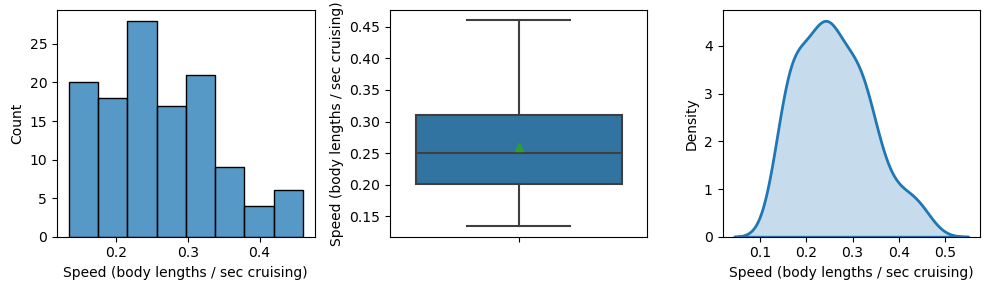

In [25]:
# looking at ALL data for a specified column
col = 'Speed (body lengths / sec cruising)'
f,[a1,a2,a3] = plt.subplots(1,3,figsize=(10,3))
a1=sns.histplot(ax=a1, x=df[col])
a2=sns.boxplot(ax=a2, y=df[col], showmeans=True)
a3=sns.kdeplot(ax=a3, x=df[col], fill=True, linewidth=2);
plt.tight_layout()
plt.show()

Speed (body lengths / sec cruising)


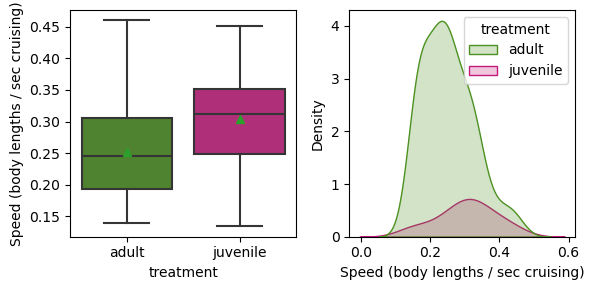

In [26]:
# comparing control vs. treatment for a specified column (col)
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
sns.boxplot(ax=a1, x=df['treatment'], palette=palette, y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

Speed (body lengths / sec cruising)


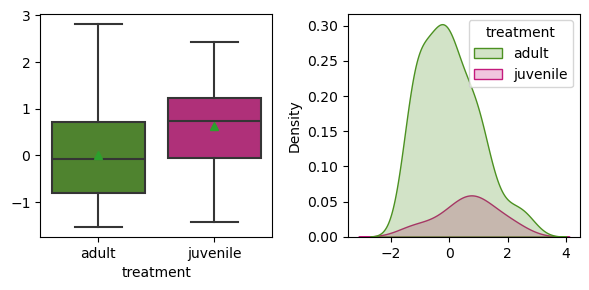

In [27]:
# Converting to ZSCORES (ended up not going in this direction . . . )
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
conditions = df['Condition'].values
zscores = np.zeros(len(df[col].values))
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
control_mean = np.nanmean(control_data)
control_std = np.nanstd(control_data)
exp_std = np.nanstd(exp_data)

for i, val in enumerate(df[col].values):
    if conditions[i] == 0: # control
        zscores[i] = (val-control_mean) / control_std
    elif conditions[i] == 1: # exp
        zscores[i] = (val-control_mean) / exp_std

sns.boxplot(ax=a1, x=df['treatment'], y=zscores, palette=palette, showmeans=True)
sns.kdeplot(ax=a2, x=zscores, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

In [28]:
# T-test using fancy statsmodels
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
levene=stats.levene(control_data, exp_data)
if levene.pvalue < 0.1:
    var = 'unequal'
    print('unequal variance')
else:
    var = 'pooled'
model = sms.CompareMeans.from_data(control_data, exp_data)
print(model.summary(usevar=var))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.0515      0.019     -2.780      0.006      -0.088      -0.015


In [29]:
# looking for correlations within the dataset
corrmat = df.corr(numeric_only=True)
sns.heatmap(corrmat,cmap=cmap) # 'bwr' # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.show()

TypeError: corr() got an unexpected keyword argument 'numeric_only'

# Linear Regression 

In [30]:
# Try a linear regression with X as 'Condition' and Y as a column of interest
import statsmodels.api as sm
Y = df[col] # col is from above, or reset here
X = df['Condition'] # 'Condition' R2 = 0.47, Speed R2 = 0.392 for swing duration
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Speed (body lengths / sec cruising)   R-squared:                       0.060
Model:                                             OLS   Adj. R-squared:                  0.052
Method:                                  Least Squares   F-statistic:                     7.726
Date:                                 Fri, 05 Apr 2024   Prob (F-statistic):            0.00631
Time:                                         11:22:52   Log-Likelihood:                 143.75
No. Observations:                                  123   AIC:                            -283.5
Df Residuals:                                      121   BIC:                            -277.9
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2518      0.007     33.708      0.000       0.237       0.267
Condition      0.0515      0.019      2.780      0.006       0.015       0.088
==============================================================================
Omnibus:                        4.109   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                4.107
Skew:                           0.440   Prob(JB):                        0.128
Kurtosis:                       2.839   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

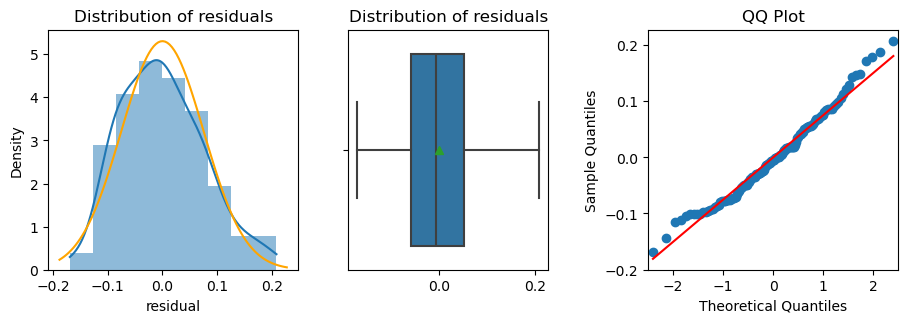

In [31]:
# check residuals from linear regression - are they normally distributed?
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_axes([0.1,0.1,0.25,0.8])
ax2 = fig.add_axes([0.4,0.1,0.2,0.8])
ax3 = fig.add_axes([0.7,0.1,0.25,0.8])

mu, std = stats.norm.fit(model_result.resid)

# plot the residuals
sns.histplot(ax=ax1, x=model_result.resid, stat="density", linewidth=0, kde=True)
ax1.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = ax1.get_xlim() # the minimum and maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values for the normal curve
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(ax=ax1, x=x, y=p, color="orange")

sns.boxplot(ax=ax2, x=model_result.resid, showmeans=True)
ax2.set(title="Distribution of residuals")

sm.qqplot(model_result.resid, line='s',ax=ax3)
ax3.set(title="QQ Plot")

plt.show()

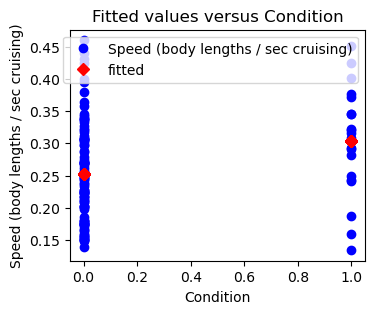

In [32]:
f,a = plt.subplots(1,1,figsize=(3.8,3))
sm.graphics.plot_fit(model_result, 1, vlines=False, ax=a)
plt.show()

# multiple linear regression
### aka ANCOVA (analysis of covariance sez Brooks)

In [33]:
# could do, for example, condition and speed vs. swing duration
# or condition and speed vs. swing duration
Y = df['Swing duration (lateral legs)']
X = df[['Condition', 'Speed (body lengths / sec cruising)']] 
X = sm.add_constant(X)
X.head(3)

,const,Condition,Speed (body lengths / sec cruising)
0,1.0,1,0.316735
1,1.0,1,0.292753
2,1.0,1,0.307873


In [34]:
model = sm.OLS(Y, X)
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Swing duration (lateral legs)   R-squared:                       0.375
Model:                                       OLS   Adj. R-squared:                  0.364
Method:                            Least Squares   F-statistic:                     35.94
Date:                           Fri, 05 Apr 2024   Prob (F-statistic):           5.89e-13
Time:                                   11:23:00   Log-Likelihood:                 285.92
No. Observations:                            123   AIC:                            -565.8
Df Residuals:                                120   BIC:                            -557.4
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.3211      0.008     42.179      0.000       0.306       0.336
Condition                               0.0272      0.006      4.502      0.000       0.015       0.039
Speed (body lengths / sec cruising)    -0.2318      0.029     -8.067      0.000      -0.289      -0.175
==============================================================================
Omnibus:                        1.724   Durbin-Watson:                   1.155
Prob(Omnibus):                  0.422   Jarque-Bera (JB):                1.712
Skew:                          -0.214   Prob(JB):                        0.425
Kurtosis:                       2.611   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

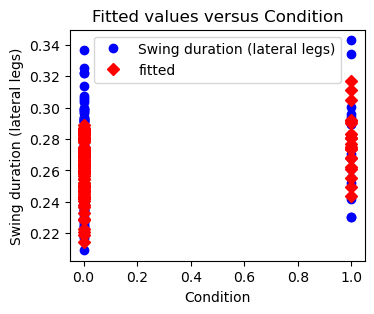

In [35]:
f,a = plt.subplots(1,1,figsize=(3.8,3))
sm.graphics.plot_fit(model_res,1, vlines=False, ax=a)
plt.show()

# Functions for pairwise boxplots and stats

T-test p-val 0.0372


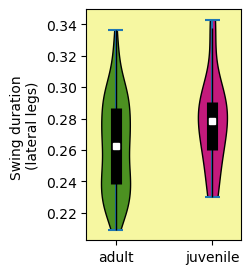

In [52]:
def compViolPlot(ax,df,col,pcolors,scatter=True):
    
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
        
    xpos = [1,2]

    violins = ax.violinplot(data_to_plot, widths=0.3, showmeans=False, showextrema=False)
    
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(pcolors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
        # add scatter over the violin
        if scatter:
            a = 0.7 # alpha
            sz = 4 # size
            sc = 'royalblue' # [ 0.76, 0.86, 0.85 ] # 'k' 'w' # marker color
            ji = 0.02 # jitter around midline
            xScatter = np.random.normal(1, ji, size=len(data_to_plot[i]))
            ax.scatter(xpos[i], data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
        # homemade box plot
        q1, median, q3 = np.percentile(data_to_plot[i], [25, 50, 75])
        vals = np.sort(data_to_plot[i])

        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

        whisk_min, whisk_max = lower_adjacent_value, upper_adjacent_value
        ax.vlines(xpos[i], whisk_min, whisk_max, color='k', linestyle='-', lw=1)
        ax.vlines(xpos[i], q1, q3, color='k', linestyle='-', lw=8)
        ax.plot(xpos[i],median,'sw',markersize=5)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)

    ax.set_xlim([0.7,2.3])
    
    return ax, data_to_plot

def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 5 # marker size
    ji = 0.02 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print([np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print([np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()

# test comparison plot
f,ax = plt.subplots(1,1,figsize=(2,3))
col = 'Swing duration (lateral legs)'

# box plot comparison
# ax, data_to_plot = compBoxPlot(ax,df,col)

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,4))
plt.show()



Mann-Whitney U p-val 0.0


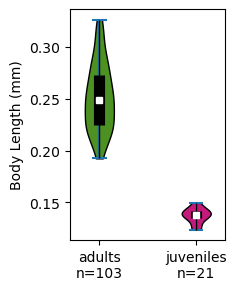

In [53]:
col = 'Body Length (mm)' # 'Speed (body lengths / sec cruising)' # 
f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],False)
pval, test = pairwiseStats(data_to_plot)
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
ax.set_xticks([1,2],['adults\nn=103','juveniles\nn=21']) # comment off if want default ticks
plt.show()

T-test p-val 0.0063139


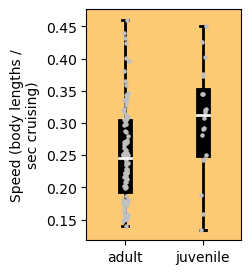

In [37]:
col = 'Speed (body lengths / sec cruising)' # 'Body Length (mm)' # 
f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,df,col)
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,7))
plt.show()

# Arrays of boxplots

['Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U']
[0.0, 0.039, 0.006, 0.818, 0.026]
[0.0, 0.11, 0.036, 1.0, 0.097]


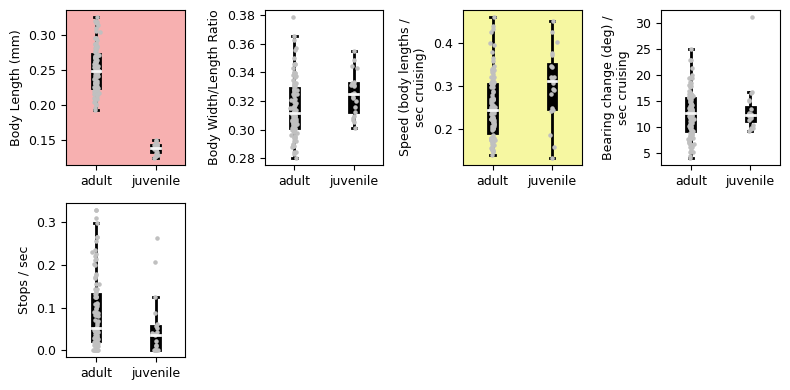

In [38]:
boxArray(4,path_summaries_df,path_cols)

['Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U']
[0.051, 0.037, 0.0, 0.0, 0.0, 0.001, 0.231, 0.838, 0.017, 0.717, 0.034]
[0.213, 0.177, 0.0, 0.001, 0.004, 0.005, 0.852, 1.0, 0.114, 1.0, 0.177]


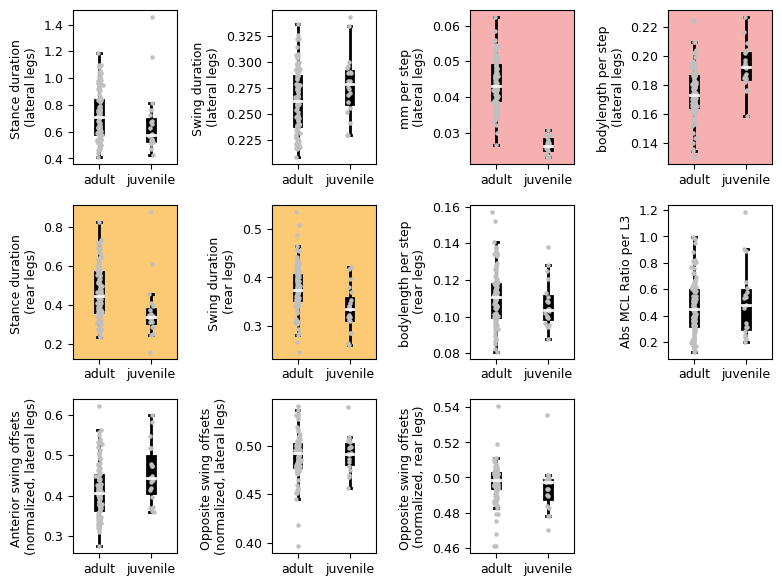

In [39]:
boxArray(4,step_summaries_df,step_cols)

['Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'T-test']
[0.401, 0.001, 0.789, 0.878, 0.744]
[1.0, 0.012, 1.0, 1.0, 1.0]


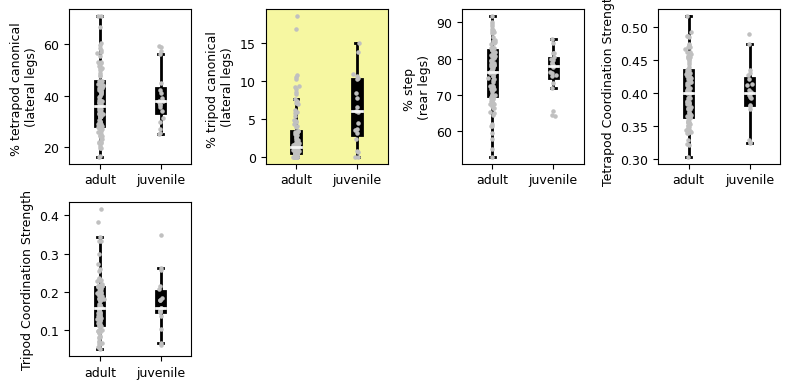

In [40]:
boxArray(4,gait_summaries_df,gait_cols)

# Phenotype Heatmaps and Multiple Comparisons

In [41]:
# Clean up category labels for heatmap plot
# for x in path_cols + step_cols + gait_cols:
#     print("'" + x + "',")
# collabs = path_cols + step_cols + gait_cols # OR
collabs = [
'Body Length',
'Body Width/Length Ratio',
'Body length / sec cruising',
'Bearing change / sec cruising',
'Stops / sec',
'Stance duration (lateral)',
'Swing duration (lateral)',
'mm per step (lateral)',
'Body length / step (lateral)',
'Stance duration (rear)',
'Swing duration (rear)',
'Body length / step (rear)',
'MCL logratio L3/R3',
'Anterior offsets (lateral)',
'Opposite offsets (lateral)',
'Opposite offsets (rear)',
'% tetrapod canonical (lateral)',
'% tripod canonical (lateral)',
'% step (rear)',
'Tetrapod Coordination Strength',
'Tripod Coordination Strength',
]


label, log2ratio, adjusted pval
Body Length (mm) -0.8752904955726969 4.553398979866397e-11
Body Width/Length Ratio 0.04322263432299069 0.24640035957914685
Speed (body lengths / sec cruising) 0.26842819882028074 0.069049020932886
Bearing change (deg) / sec cruising 0.08729406246731754 1.0
Stops / sec -0.7966033232238434 0.2172414125207916
Stance duration (lateral legs) -0.11470385618438848 0.3013780250878651
Swing duration (lateral legs) 0.08145767341420852 0.24640035957914685
mm per step (lateral legs) -0.721536250547219 1.0696545522427824e-10
bodylength per step (lateral legs) 0.1397574988616416 0.0011761908331012832
Stance duration (rear legs) -0.35143752980817294 0.007654554942989265
Swing duration (rear legs) -0.16756370954314537 0.00869360426709908
bodylength per step (rear legs) -0.056562014313825335 1.0
Abs MCL Ratio per L3 0.09700160058581003 1.0
Anterior swing offsets (normalized, lateral legs) 0.13638454549261075 0.16454154848431363
Opposite swing offsets (normalized, latera

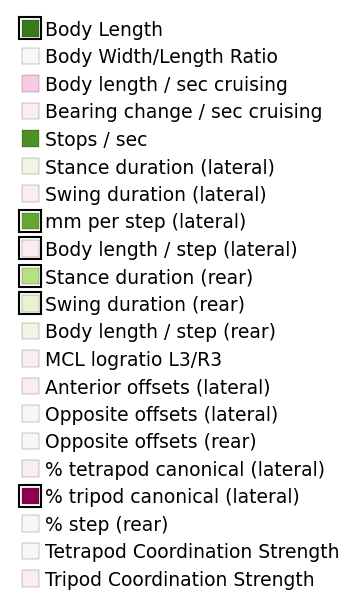

In [42]:
# function for Z-scores, log ratio plots, and combining dataframes
def pairZscore(data,conditions): # I do not use this function anywhere
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores

def ratioPlot(ax, dflist, colslist, collabs, control='control', cmap='bwr', plotLabels = True):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list of lists of columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = np.sum(np.array([len(x) for x in colslist]))
    
    # make empty containers for log ratios and pvals and labels
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through dflist and colslist
    for i,columns in enumerate(colslist):
        
        df = dflist[i].copy()

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        for column in columns:
            
            data = df[column].values
            
            control_data = data[np.where(conditions==0)]
            exp_data = data[np.where(conditions==1)]
            
            # remove nan (no data)
            control_data = control_data[~np.isnan(control_data)]
            exp_data = exp_data[~np.isnan(exp_data)]
    
            # get pval for this column            
            pval, test = pairwiseStats([control_data, exp_data])
#             print(column, pval, test) # testing
            pvals[idx] = pval
    
            # get label for this column
            labels[idx] = column
            
            # get log2(experiment/control) ratio for this column (CLR causes trouble!)
            log2ratios[idx] = np.log2(np.mean(exp_data)/np.mean(control_data))          
    
            idx += 1

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.25 # level for text above the lower edge of each square

    ylevel = len(labels) + 1
    
    big_box = 0.4
    small_box = 0.3

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        square_center_x = 0.53
        square_center_y = ylevel + 0.505
        
        # plot a box around square if significant
        if adj_pvals[i] < 0.05:
            linewidth = 0.1 # 0.1 or 3 or 5
            ec = 'k'
#             ax.text(0.25,ylevel,s='*',fontsize=axis_fontsize) # or comment out
            square = patches.Rectangle((square_center_x-big_box, square_center_y-big_box), 
                                       2*big_box, 2*big_box, linewidth=1, edgecolor='k', facecolor='w')        
            ax.add_patch(square)
        else:
            linewidth = 0.1
            ec = 'k'
        
        square = patches.Rectangle((square_center_x-small_box+0.025, square_center_y-small_box-0.01), 
                                   2*small_box, 2*small_box, linewidth=linewidth, 
                                   edgecolor=ec, facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        if plotLabels:
#             label = label.replace('normalized, ','')
#             label = label.replace(' legs','')
            ax.text(1.1,ylevel+ytext,s=collabs[i],fontsize=tick_fontsize, horizontalalignment='left')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([2,len(labels) + 2])
    ax.set_aspect('equal')
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, log2ratios, pvals, adj_pvals, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
cols = [path_cols, step_cols, gait_cols]
f,ax = plt.subplots(figsize=(2,5), dpi=150, facecolor=(1,1,1,0))
print()
ax, log2_ratios, pvals, adj_pvals, labels = ratioPlot(ax, dfs, cols, collabs,
                                                      control, cmap, True) # 'control' or 'exemplaris' or 'adult'

# add label for comparison
comparison= control + ' vs. ' + experimental
# ax.text(0.1,1.7,s=comparison,rotation=270,fontsize=tick_fontsize, verticalalignment='top')

print('label, log2ratio, adjusted pval')
for i, lab in enumerate(labels):
    print(lab, log2_ratios[i], adj_pvals[i])
plt.show()

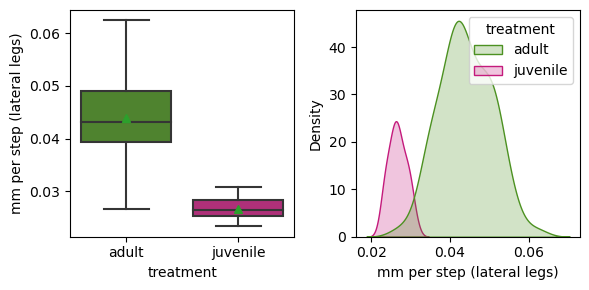

In [45]:
# comparing control vs. treatment for a specified column (col)
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
col = 'mm per step (lateral legs)' # 'Speed (body lengths / sec cruising)' # 'Body Length (mm)'
sns.boxplot(ax=a1, x=df['treatment'], palette=palette, y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

# Pairwise gait style comparisons

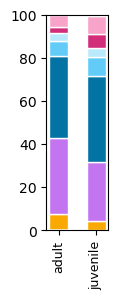

In [46]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in gdf.columns if '%' in x]
        columns = [x for x in columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize, rotation=90)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100]) 

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'lateral', False) # False to hide legend and Y label
plt.show()

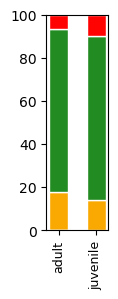

In [47]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'rear', False) # False to hide legend and Y label
plt.show()

# ternary plots and compositional statistics

In [48]:
from gaitFunctions import colorBoxplot
from gaitFunctions import pairwiseStats
import mpltern
import composition_stats as cs
gait_summaries_df.head(5)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR pentapod (lateral legs),CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs)
0,ea_1mar_tardigrade09_juvenile,juvenile,tardigrade09,1mar,823,6.804374,29.526124,35.601458,10.935601,4.495747,...,0.128167,-0.077938,0.825814,0.469663,-0.051032,0.529648,0.851817,0.086594,0.020523,0.362672
1,ea_20feb_tardigrade01_juvenile,juvenile,tardigrade01,20feb,611,3.927987,33.387889,36.661211,8.510638,8.510638,...,0.251085,-0.048605,0.575108,1.107848,-1.088174,0.324879,-0.236618,0.298275,-0.151622,1.065997
2,ea_22feb_tardigrade02_juvenile,juvenile,tardigrade02,22feb,525,2.095238,23.428571,29.904762,18.285714,4.380952,...,-0.103152,-0.252306,1.339911,0.443797,0.888074,0.991476,0.608228,0.162292,-0.002426,0.439991
3,ea_22feb_tardigrade03_juvenile,juvenile,tardigrade03,22feb,439,2.277904,30.296128,39.179954,16.856492,3.189066,...,0.153911,0.017841,1.258527,0.126259,-6.874137,0.347175,-4.410628,0.523512,-0.010370,-0.422564
4,ea_22mar_tardigrade15_juvenile,juvenile,tardigrade15,22mar,383,1.305483,15.404700,59.268930,0.783290,3.133159,...,-0.522436,0.431761,-1.810462,0.108573,1.458329,0.483639,0.230444,-0.102163,0.044287,0.407047


In [49]:
exp = gait_summaries_df[gait_summaries_df['treatment']==experimental]
con = gait_summaries_df[gait_summaries_df['treatment']==control]
print(np.shape(exp), np.shape(con))

(20, 33) (103, 33)


In [50]:
stand_rear_exp = exp['% stand (rear legs)'].values
stand_rear_con = con['% stand (rear legs)'].values
step_rear_exp = exp['% step (rear legs)'].values
step_rear_con = con['% step (rear legs)'].values
hop_rear_exp = exp['% hop (rear legs)'].values
hop_rear_con = con['% hop (rear legs)'].values

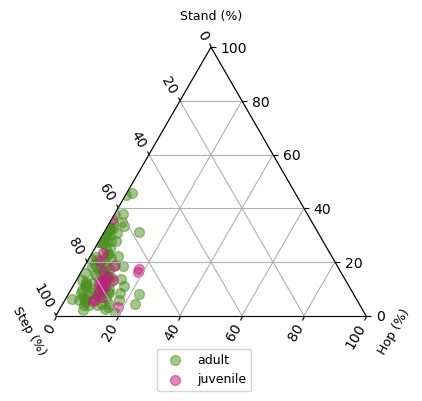

In [51]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(stand_rear_con, step_rear_con, hop_rear_con,
           color=con_color,s=50,alpha=0.5,label=control)
ax.scatter(stand_rear_exp, step_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=experimental)

ax.set_tlabel("Stand (%)", fontsize=tick_fontsize)
ax.set_llabel("Step (%)", fontsize=tick_fontsize)
ax.set_rlabel("Hop (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.55, -0.9, 0.5, 0.5) )# , loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

In [52]:
stand_lateral_exp = exp['% stand (lateral legs)'].values
stand_lateral_con = con['% stand (lateral legs)'].values

pentapod_exp = exp['% pentapod (lateral legs)'].values
pentapod_con = con['% pentapod (lateral legs)'].values

tetrapod_canonical_exp = exp['% tetrapod canonical (lateral legs)'].values
tetrapod_canonical_con = con['% tetrapod canonical (lateral legs)'].values

tetrapod_gallop_exp = exp['% tetrapod gallop (lateral legs)'].values
tetrapod_gallop_con = con['% tetrapod gallop (lateral legs)'].values

tetrapod_other_exp = exp['% tetrapod other (lateral legs)'].values
tetrapod_other_con = con['% tetrapod other (lateral legs)'].values

tetrapod_total_exp = exp['% tetrapod total (lateral legs)'].values
tetrapod_total_con = con['% tetrapod total (lateral legs)'].values

tripod_canonical_exp = exp['% tripod canonical (lateral legs)'].values
tripod_canonical_con = con['% tripod canonical (lateral legs)'].values

tripod_other_exp = exp['% tripod other (lateral legs)'].values
tripod_other_con = con['% tripod other (lateral legs)'].values

tripod_total_exp = exp['% tripod total (lateral legs'].values
tripod_total_con = con['% tripod total (lateral legs'].values

# 'total' here is pentapod + tetrapod + tripod
total_exp =  pentapod_exp + tetrapod_total_exp + tripod_total_exp
total_con =  pentapod_con + tetrapod_total_con + tripod_total_con

pentapod_percent_exp = pentapod_exp / total_exp
tetrapod_percent_exp = tetrapod_total_exp / total_exp
tripod_percent_exp = tripod_total_exp / total_exp
# print(pentapod_percent_exp + tetrapod_percent_exp + tripod_percent_exp)# testing OK

pentapod_percent_con = pentapod_con / total_con
tetrapod_percent_con = tetrapod_total_con / total_con
tripod_percent_con = tripod_total_con / total_con
# print(pentapod_percent_con + tetrapod_percent_con + tripod_percent_con)# testing OK


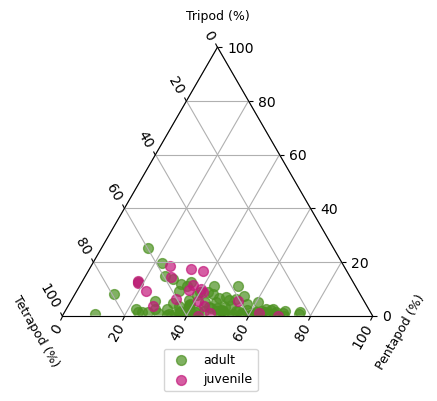

In [53]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

# total
# ax.scatter(pentapod_percent_con, tetrapod_percent_con, tripod_percent_con,c=con_color,s=10,label=control)
# ax.scatter(pentapod_percent_exp, tetrapod_percent_exp, tripod_percent_exp,c=exp_color,s=10,label=experimental)
# ax.set_tlabel("Pentapod (%)")
# ax.set_llabel("Tetrapod (%)")
# ax.set_rlabel("Tripod (%)")

# canonical
ax.scatter(tripod_canonical_con, tetrapod_canonical_con, pentapod_con, 
           color=con_color,s=50,alpha=0.7,label=control)
ax.scatter(tripod_canonical_exp, tetrapod_canonical_exp, pentapod_exp, 
           color=exp_color,s=50,alpha=0.7,label=experimental)
ax.set_tlabel("Tripod (%)", fontsize=tick_fontsize)
ax.set_llabel("Tetrapod (%)", fontsize=tick_fontsize)
ax.set_rlabel("Pentapod (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.35, -0.7, 0.5, 0.5) )#, loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

# compositional data = log ratio transform

In [54]:
# rear legs
rear_labs = ['stand','step','hop']
treatments = gait_summaries_df.treatment.values
control_ix = np.where(treatments == control)[0]
exp_ix = np.where(treatments == experimental)[0]
rear_percentages = np.hstack([[
    gait_summaries_df['% stand (rear legs)'].values,
    gait_summaries_df['% step (rear legs)'].values,
    gait_summaries_df['% hop (rear legs)'].values
                             ]])
print(np.sum(rear_percentages,0)) # should all be 100 ... check!
rear_percentages_nozeros = cs.multiplicative_replacement(rear_percentages)
print(np.sum(rear_percentages_nozeros,0)) # should still be 100-ish ... check!
rear_clr = cs.clr(rear_percentages_nozeros)

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[ 99.99702839  99.99399599  99.99678951  99.99864491  99.99689356
  99.99688287  99.99737874  99.99621028  99.99695757  99.99652436
  99.9939734   99.99734958  99.99680566  99.99699554  99.99677013
  99.99387769  99.9961833   99.99883678 100.0000661   99.99768171
  99.9993857   99.99806628  99.99967343  99.9963646   99.99953713
  99.99685801  99.99827931  99.99245688 100.0

In [55]:
print(gait_summaries_df.columns)

Index(['Identifier', 'treatment', 'individual', 'date', 'Number of frames',
       '% stand (lateral legs)', '% pentapod (lateral legs)',
       '% tetrapod canonical (lateral legs)',
       '% tetrapod gallop (lateral legs)', '% tetrapod other (lateral legs)',
       '% tetrapod total (lateral legs)', '% tripod canonical (lateral legs)',
       '% tripod other (lateral legs)', '% tripod total (lateral legs',
       '% other (lateral legs)', '% stand (rear legs)', '% hop (rear legs)',
       '% step (rear legs)', 'Tetrapod Coordination Strength',
       'Tetrapod Bout Speed (bodylength / s)', 'Tripod Coordination Strength',
       'Tripod Bout Speed (bodylength / s)', 'CLR stand (lateral legs)',
       'CLR pentapod (lateral legs)', 'CLR tetrapod canonical (lateral legs)',
       'CLR tetrapod gallop (lateral legs)',
       'CLR tetrapod other (lateral legs)',
       'CLR tripod canonical (lateral legs)',
       'CLR tripod other (lateral legs)', 'CLR other (lateral legs)',
       'CLR

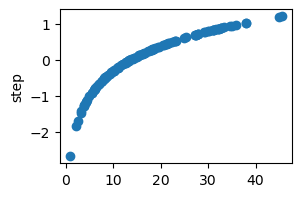

In [56]:
# rear_clr should still be proportional to rear_percentages, no?
col = 1 # 0=stand, 1=step, 2=hop
f,a = plt.subplots(1,1,figsize=(3,2),facecolor=(1,1,1,0))
a.scatter(rear_percentages[0],rear_clr[0])
a.set_ylabel(rear_labs[col])
plt.show()
# yes, in a loggish way

p =  0.789232 by Mann-Whitney U


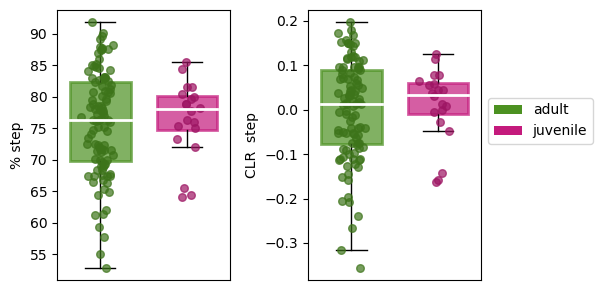

In [60]:
# REAR boxplot
col = 1 # 0=stand, 1=step, 2=hop
from matplotlib.patches import Patch
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
rear_boxdata = [rear_percentages[col][control_ix], rear_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,rear_boxdata,[con_color,exp_color],30,0.8)
a1.set_ylabel('% ' + rear_labs[col])

rear_clr_boxdata = [rear_clr[col][control_ix], rear_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,rear_clr_boxdata,[con_color,exp_color],30,0.8)
a2.set_ylabel('CLR  '+ rear_labs[col])

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
a2.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

plt.tight_layout()

pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
plt.show()



p =  0.789232 by Mann-Whitney U


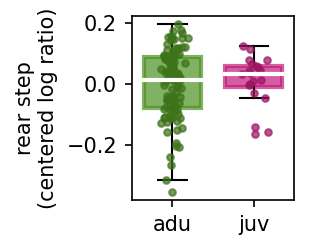

In [63]:
# just CLR from above
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)
a,bp=colorBoxplot(a,rear_clr_boxdata,[con_color,exp_color],10,0.8)
a.set_ylabel('rear ' + rear_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control[:3], experimental[:3]])

plt.show()



In [64]:
# LATERAL legs
lateral_percentages = np.hstack([[
    gait_summaries_df['% stand (lateral legs)'].values,
    gait_summaries_df['% pentapod (lateral legs)'].values,
    gait_summaries_df['% tetrapod canonical (lateral legs)'].values,
    gait_summaries_df['% tetrapod gallop (lateral legs)'].values,
    gait_summaries_df['% tetrapod other (lateral legs)'].values,
    gait_summaries_df['% tripod canonical (lateral legs)'].values,
    gait_summaries_df['% tripod other (lateral legs)'].values,
    gait_summaries_df['% other (lateral legs)'].values
                             ]])
lat_labs = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
       'tripod canonical','tripod other',' other']

print(np.sum(lateral_percentages,0)) # should all be 100 ... check!
lateral_percentages_nozeros = cs.multiplicative_replacement(lateral_percentages)
print(np.sum(lateral_percentages_nozeros,0)) # should still be 100-ish ... check!
lateral_clr = cs.clr(lateral_percentages_nozeros)



[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[99.98954315 99.99354163 99.98385944 99.99296528 99.98665955 99.98029071
 99.98190623 99.98571514 99.9886774  99.98890233 99.97593247 99.99293582
 99.9807234  99.98538829 99.98662376 99.98455819 99.98449034 99.99368892
 99.99812722 99.98439737 99.99529155 99.99160459 99.99540265 99.98513892
 99.99354885 99.98815352 99.99150335 99.96587695 99.99536811 99.99275707
 99.996845

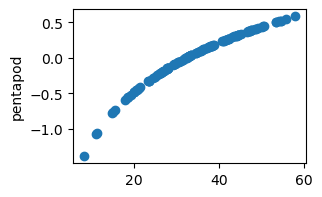

In [65]:
# lateral clr should still be proportional to lateral percentages, no?
col = 1 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,a = plt.subplots(1,1,figsize=(3,2))
a.scatter(lateral_percentages[col],lateral_clr[col])
a.set_ylabel(lat_labs[col])
plt.show()
# yes, in a loggish way

p =  0.003627 by T-test


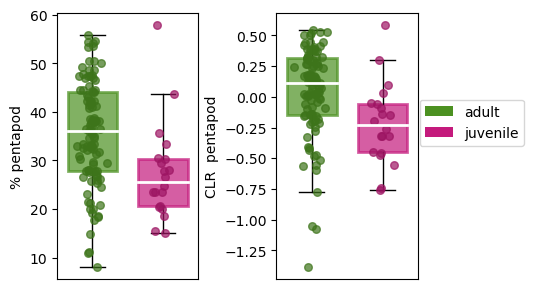

In [69]:
# LATERAL boxplot a:  % for ex vs. ram, 2: clr for ex vs. ram
from matplotlib.patches import Patch
col = 1 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
lateral_boxdata = [lateral_percentages[col][control_ix], lateral_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,lateral_boxdata,[con_color,exp_color],30,0.8)
a1.set_ylabel('% ' + lat_labs[col])

lateral_clr_boxdata = [lateral_clr[col][control_ix], lateral_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,lateral_clr_boxdata,[con_color,exp_color],30,0.8)
a2.set_ylabel('CLR  '+ lat_labs[col])

pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
# a2.set_ylim([-3,2])
a2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 0.2, 0.5, 0.5))
plt.tight_layout()
plt.show()



p =  0.003627 by T-test


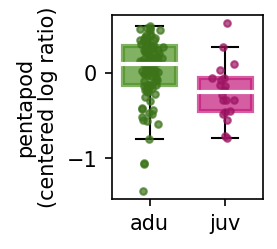

In [71]:
# just CLR from above
f,a = plt.subplots(1,1,figsize=(1.3,1.6), facecolor=(1,1,1,0),dpi=150)
a,bp=colorBoxplot(a,lateral_clr_boxdata,[con_color,exp_color],10,0.8)
a.set_ylabel(lat_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))
# a.set_ylim([-2,4])
a.set_xticks([1,2],[control[:3],experimental[:3]])
plt.show()

p =  0.377633 by T-test


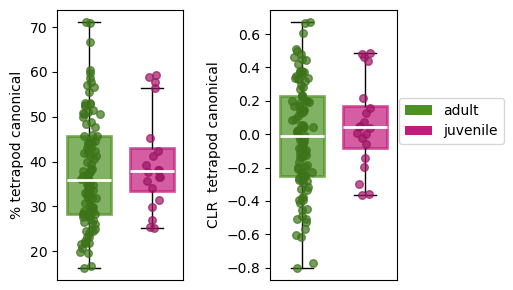

In [105]:
# LATERAL boxplot a:  % for ex vs. ram, 2: clr for ex vs. ram
from matplotlib.patches import Patch
col = 2 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
lateral_boxdata = [lateral_percentages[col][control_ix], lateral_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,lateral_boxdata,[con_color,exp_color],30,0.8)
a1.set_ylabel('% ' + lat_labs[col])

lateral_clr_boxdata = [lateral_clr[col][control_ix], lateral_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,lateral_clr_boxdata,[con_color,exp_color],30,0.8)
a2.set_ylabel('CLR  '+ lat_labs[col])

pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
a2.legend(handles=legend_elements, bbox_to_anchor=(1.4, 0.2, 0.5, 0.5))
plt.tight_layout()
plt.show()



p =  0.377633 by T-test


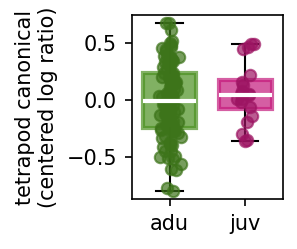

In [106]:
# just CLR from above
f,a = plt.subplots(1,1,figsize=(1.3,1.6), facecolor=(1,1,1,0),dpi=150)
a,bp=colorBoxplot(a,lateral_clr_boxdata,[con_color,exp_color],30,0.8)
a.set_ylabel(lat_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))
a.set_xticks([1,2],[control[:3],experimental[:3]])
plt.show()

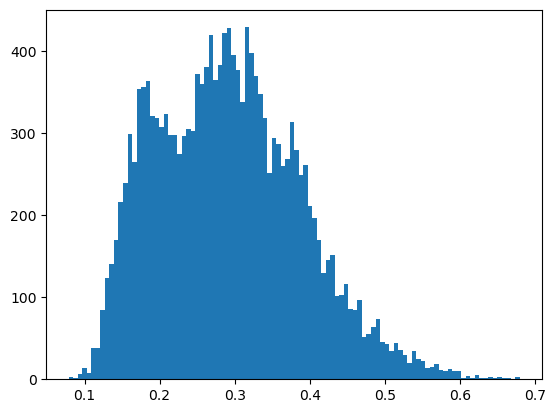

In [72]:
# Swing duration in different speed bins

# add column of speed body-length / sec to step_timing_df
# need to divide speed_during_step_scaled by bodylength for every line
# print(step_timing_df.columns)
# print(path_summaries_df.columns)

bodylength_dict = dict(zip(path_summaries_df.Identifier.values,path_summaries_df['Body Length (mm)'].values))
# print(bodylength_dict)

uniq_ids = step_timing_df.uniq_id.values
scaled_speeds = step_timing_df['speed_during_step_scaled'].values
speed_bodylength = [scaled_speeds[i]/bodylength_dict[uniq_id] for i,uniq_id in enumerate(uniq_ids)]
step_timing_df['Speed (bodylength / step)'] = speed_bodylength

plt.hist(speed_bodylength,bins=100)
plt.show()

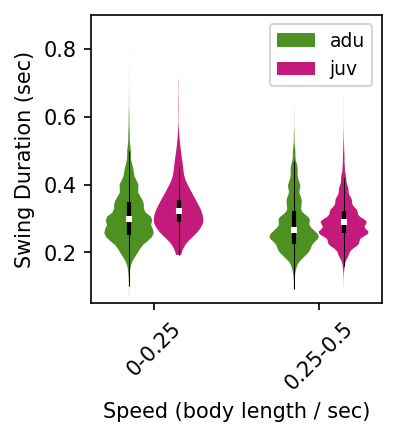

In [81]:
# for each speed bin (0.05 of bodylengths), get number of steps in each treatment
# and get swing duration for each of these steps 
# (we are trying to see if swing durations differ in same speed bin)
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def speedPartitionViolins(ax,step_timing_df,col,control,experimental,boundaries):

    con_boxdata = []
    exp_boxdata = []

    for i,lowb in enumerate(boundaries[:-1]):
        highb = boundaries[i+1]
        steps = step_timing_df[step_timing_df['Speed (bodylength / step)'].between(lowb,highb)]
        con_steps = steps[steps['treatment']==control]
        exp_steps = steps[steps['treatment']==experimental]

        con_swings = con_steps[col].values
        exp_swings = exp_steps[col].values

        con_boxdata.append(con_swings)
        exp_boxdata.append(exp_swings)

    pos_buffer = 0.15
    con_positions = [i-pos_buffer for i in np.arange(1,len(con_boxdata)+1)]
    exp_positions = [i+pos_buffer for i in np.arange(1,len(con_boxdata)+1)]

    con_v = ax.violinplot(con_boxdata, positions = con_positions, widths=0.3,
                         showmeans=False, showextrema=False)
    exp_v = ax.violinplot(exp_boxdata, positions = exp_positions, widths=0.3,
                         showmeans=False, showextrema=False)

    violins = [con_v, exp_v]
    cols = [con_color,exp_color]
    data = [con_boxdata, exp_boxdata]
    positions = [con_positions, exp_positions]

    for i,violin in enumerate(violins):
        for pc in violin['bodies']:
            pc.set_facecolor(cols[i])
            pc.set_edgecolor(None)
            pc.set_alpha(1)

        for j, data_bin in enumerate(data[i]):
            quartile1, median, quartile3 = np.percentile(data_bin, [25, 50, 75])
            whiskers = adjacent_values(np.sort(data_bin),quartile1,quartile3)
            whisk_min = whiskers[0]
            whisk_max = whiskers[1]

            ax.vlines(positions[i][j], whisk_min, whisk_max, color='k', linestyle='-', lw=0.5)
            ax.vlines(positions[i][j], quartile1, quartile3, color='k', linestyle='-', lw=2)
            ax.plot(positions[i][j],median,'sw',markersize=2)

    xtick_labs = [str(x) + '-' + str(boundaries[i+1]) for i, x in enumerate(boundaries[:-1])]

    ax.set_xticks(np.arange(1,len(con_boxdata)+1), xtick_labs, rotation=45)
    ax.set_xlabel('Speed (body length / sec)')
    ax.legend([con_v['bodies'][0],exp_v['bodies'][0]], [control[:3],experimental[:3]],fontsize=tick_fontsize)

    return ax

# boundaries = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45] # granular
# boundaries = [0,0.1,0.2,0.3,0.4,0.5] # middle
boundaries = [0, 0.25, 0.5] # broad
data_col = 'swing'

f,a = plt.subplots(1,1,figsize=(2.5,2.5),dpi=150, facecolor=(1,1,1,0))
a = speedPartitionViolins(a,step_timing_df,data_col,control,experimental,boundaries)
# a.set_ylabel(data_col)
a.set_ylim([0.05,0.9])
a.set_ylabel('Swing Duration (sec)')
plt.show()

# SCRUNCH from Emma data of adults vs. juveniles

In [ ]:
baby_scrunch_time = np.array([0.02542372881, 0.1206896552, 0.08064516129,0.03921568627,0,0,0,0.03703703704,0.02575107296,0.01652892562,0.01,0.0701754386,0.08333333333,0.03703703704,0.08571428571])
baby_st_time = np.array([0.07627118644,0,
0.008064516129,
0.01307189542,
0.06140350877,
0,
0.04,
0.02469135802,
0.02575107296,
0.03305785124,
0.03,
0.01754385965,
0.02083333333,
0.03703703704,
0.02857142857])
adult_scrunch_time = np.array([
    0,
0,
0.02702702703,
0.07407407407,
0.05660377358,
0.01724137931,
0.06382978723,
0.075,
0,
0.1,
])
adult_st_time = np.array([
    0.01818181818,
0.01785714286,
0.02702702703,
0.03703703704,
0.05660377358,
0.08620689655,
0.06382978723,
0.05,
0,
0
])

In [ ]:
f,[a1,a2] = plt.subplots(1,2,figsize=(7,3))
scrunch_boxdata = [adult_scrunch_time, baby_scrunch_time]
st_boxdata = [adult_st_time, baby_st_time]

a1,bp1=colorBoxplot(a1,scrunch_boxdata,[con_color,exp_color],10,0.8)
a1.set_ylabel('Scrunch / sec')

a2,bp2=colorBoxplot(a2,st_boxdata,[con_color,exp_color],10,0.8)
a2.set_ylabel('Scrunch-turn / sec')

pval, test = pairwiseStats(scrunch_boxdata)
print('Scrunch p = ', np.round(pval,6), 'by', test)

pval, test = pairwiseStats(st_boxdata)
print('Scrunch-turn p = ', np.round(pval,6), 'by', test)

plt.tight_layout()
plt.show()
